# Lesson 5a project: Filling histograms on a GPU

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba.cuda
import numba as nb
import uproot
import awkward as ak
from hist import Hist
ak.numba.register_and_check()

In the following file, there are 10 million dimuon masses (real data, computed on a GPU).

In [ ]:
with uproot.open("../data/dimuon_mass.root:tree/mass") as branch:
    mass = cp.asarray(branch.array(library="np"))

mass

In [ ]:
type(mass)

The dimuon mass values are now on the GPU, and your goal is to make a histogram of them, which would look like this:

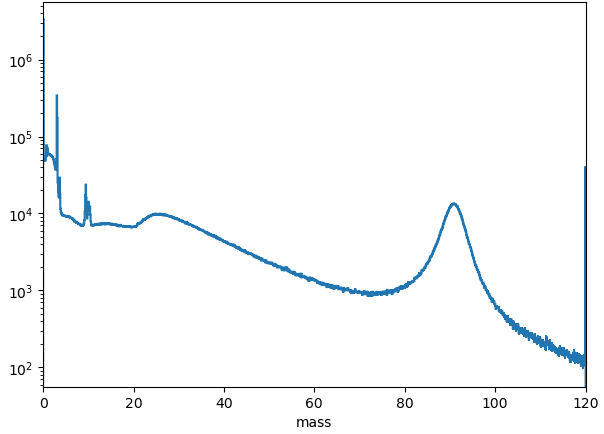

`Hist` can only fill histograms on the CPU (currently), so we will only be using it to turn an array of bin values into a plot:

```python
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values.get()

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");
```

in which `bin_values` is a CuPy array with 1200 entries, representing the number of `mass` values in regular bins from `0` GeV to `120` GeV.

In [ ]:
bin_values = cp.zeros(1200, dtype=np.uint32)

For a given value from `mass`, the bin to fill is

In [ ]:
@nb.cuda.jit(device=True)
def bin_index(x):
    if x < 0:
        return 0
    elif x >= 120:
        return 1199
    else:
        return x * 10

where bins `0` and `1199` are used for underflow and overflow, respectively.

You might want to fill the histogram with

```python
bin_values[bin_index(mass[i])] += 1
```

but multiple threads would attempt to write to the same element of `bin_values` at the same time, and the result would be wrong.

<br><br><br><br><br>

Exercises 1 and 2 are not to be done one after the other: _only one of the two will be practical_. Your first problem is to determine which strategy is going to work. For the strategy that can't be computed, at least set up the computation, even though it won't work.

<br><br><br><br><br>

## Exercise 1

Fill the histogram using reduction.

On a computer cluster (horizontal scaling), we submit tasks to run concurrently on non-overlapping parts of the big dataset. Each task has its own copy of the histograms to fill. It fills its own histograms, then sends them to a single computer that adds them together to get the final result.

On a GPU, what are the tasks run concurrently? If you want to process 10 million entries in the `mass` array, how many concurrent tasks will there be?

How would you make copies of `bin_values` for all of your concurrent tasks to fill? How would you sum them up at the end?

You're allowed to use [cp.sum](https://docs.cupy.dev/en/stable/reference/generated/cupy.sum.html) with an appropriate `axis` parameter to do the tree-reduction. You don't have to do it manually.

In [ ]:
@nb.cuda.jit
def fill_histogram(all_histograms, mass):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        ...

num_threads = ...
num_blocks = ...

all_histograms = ...

fill_histogram[num_blocks, num_threads](all_histograms, mass)

bin_values = ...

In [ ]:
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values.get()

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");

<br><br><br><br><br>

## Exercise 2

Fill the histogram using atomics.

In Numba, you can access CUDA's atomic intrinsics as `nb.cuda.atomic.*` functions. See [the documentation here](https://numba.readthedocs.io/en/stable/cuda/intrinsics.html).

Which function(s) could you use to do it? What `dtype` must `bin_values` have in order to use it? (You're allowed to change the `dtype` to use your preferred atomic function.)

What implications does the number of bins have on performance? What would happen if the statistical distribution were narrower or wider?

In [ ]:
@nb.cuda.jit
def fill_histogram(bin_values, mass):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        ...

num_threads = ...
num_blocks = ...

fill_histogram[num_blocks, num_threads](bin_values, mass)

In [ ]:
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values.get()

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");